In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from sklearn.metrics import r2_score


In [ ]:
forex_data_1 = yf.download('EURUSD=X', start='2020-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Removing unnecessary columns
df=forex_data_1.drop(['Open', 'High', 'Low', 'Close', 'Volume'],axis=1)
df.rename(columns={'Adj Close': 'eur'},inplace=True)
df.head(2)

,eur
Date,
2020-01-01,1.122083
2020-01-02,1.122083


In [ ]:
df = df.dropna(axis=0)

In [ ]:
training_set = df['eur']


In [ ]:
def rolling_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        value_x = data[i:(i+seq_length)]
        value_y = data[i+seq_length]
        x.append(value_x)
        y.append(value_y)

    return np.array(x),np.array(y)


In [ ]:
#Prepare the data for torch
sc = MinMaxScaler()
training_data = sc.fit_transform(np.array(training_set).reshape(-1, 1))

seq_length = 4
x, y = rolling_window(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        output, (h_out, c_out) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

Model Training


In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

### Testing

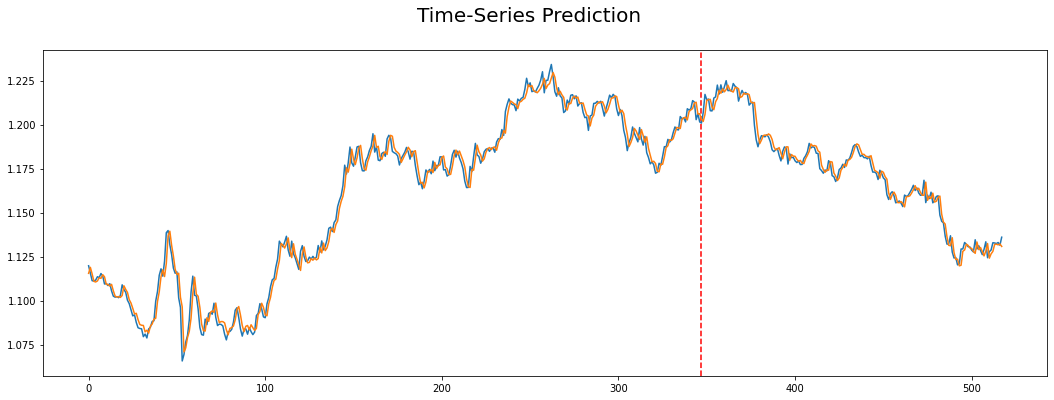

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)
plt.figure(figsize=(18,6))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction',fontsize=20)
plt.show()

In [ ]:

r2_score(data_predict,dataY_plot)

0.9869017665103355

### Check performance on new dataset

In [ ]:
test_df = yf.download('EURUSD=X', start='2022-01-01', end='2022-06-30')
test = pd.DataFrame()
test['eur'] = test_df['Adj Close']
test = test.dropna()
total= pd.concat([df['eur'],test['eur']],axis=0)

[*********************100%***********************]  1 of 1 completed


In [ ]:
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed

In [ ]:
len(test_input)

189

In [ ]:
#Prepare dataset for pytorch
sc2 = MinMaxScaler()
testing_data = sc2.fit_transform(test_input)
seq_length = 4
x_test, y_test = rolling_window(training_data, seq_length)
dataX_test = Variable(torch.Tensor(np.array(x_test)))
dataY_test = Variable(torch.Tensor(np.array(y_test)))


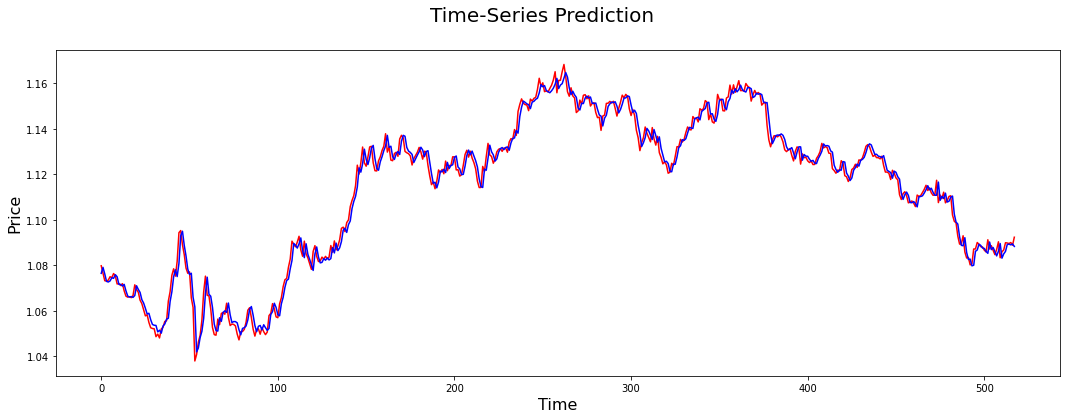

In [ ]:
#Make the predictions
lstm.eval()
test_predict = lstm(dataX_test)

data_predict = test_predict.data.numpy()
dataY_actual = dataY_test.data.numpy()

data_predict = sc2.inverse_transform(data_predict)
dataY_actual = sc2.inverse_transform(dataY_actual)
#Plot the results
plt.figure(figsize=(18,6))
plt.plot(dataY_actual,'red',label='Real Prices')
plt.plot(data_predict,'blue',label='Predicted Prices')
plt.ylabel('Price',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.suptitle('Time-Series Prediction',fontsize=20)
plt.show()

In [ ]:
r2_score(data_predict,dataY_actual)

0.9869017684504593